# **Deep Research with Bing Search & Scraping**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow now includes a dedicated scraping phase for extracting and cleaning web content:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Web Content Scraping** - Extracting, cleaning, and filtering relevant content from web pages using a ScraperAgent
4. **Content Analysis** - Summarizing scraped results and extracting key insights
5. **Report Generation** - Creating detailed research reports with proper citations
6. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- WebScraperAgent - Extracts, cleans, and filters relevant content from web pages
- SummaryAgent - Extracts key insights from scraped content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure OpenAI Configuration
AOAI_ENDPOINT=your_azure_openai_endpoint
AOAI_KEY=your_azure_openai_api_key
AOAI_API_VERSION=2024-02-01  # Optional, defaults to this value

# Model Deployment Names
reasoningModel=your_reasoning_model_deployment_name  # e.g., o1-preview
chatModel=your_chat_model_deployment_name  # e.g., gpt-4o

# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Bing Search Agent (pre-created in Azure AI Foundry)
bingSearchAgentID=your_bing_search_agent_id
BING_CONNECTION_NAME=your_bing_connection_name  # Only needed if creating agent inline
```

**Note:** This notebook extends notebook 01 by adding web scraping capabilities. Like notebook 01, it creates agents inline using the OpenAI Agents SDK, except for the Bing Search agent which must be pre-created in Azure AI Foundry.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class ScrapedWebPage(BaseModel):
    url: str = Field(..., description="The original URL that was scraped")
    title: Optional[str] = Field(None, description="The page title (if available, else None)")
    main_content: Optional[str] = Field(None, description="The main textual content of the page, cleaned and potentially truncated (if available, else None)")
    source: Optional[str] = Field(None, description="The name of the source (if available, else None)")
    published_date: Optional[str] = Field(None, description="YYYY-MM-DD (if available, else None)")
    scrape_error: Optional[str] = Field(None, description="Error message if scraping failed, else None")
    # Fields below might be added by the agent based on instructions, not the tool directly
    extraction_method: Optional[str] = Field(None, description="How content was extracted (e.g., 'tool_extracted', 'agent_filtered')") 
    relevance_score_agent: Optional[float] = Field(None, description="Agent's assessment of relevance (0-10)")
    matched_sections: Optional[List[str]] = Field(None, description="Sections identified by the agent as relevant")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating the Bing Search Agent (One-time Setup)

The following cell will **create** an **Azure AI Agent** with Bing Search capabilities. You only need to run this cell **once** to create the agent, then save its ID to your `.env` file as `bingSearchAgentID`.

If you already have a Bing Search agent created, skip this cell and use the next cell to update its instructions instead.

In [5]:
from azure.ai.agents.models import BingGroundingTool

import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_connection = project_client.connections.get(
    name=os.getenv("BING_CONNECTION_NAME")
)

bing_tool = BingGroundingTool(connection_id=bing_connection.id)

bing_search_agent = project_client.agents.create_agent(
    name="bingSearchAgent",
    description="Agent to perform web searches using Bing.",
    model=os.getenv("chatModel"),
    temperature=0.5,
    tools=bing_tool.definitions,
    instructions=f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
    """.strip()
)

### Updating Existing Bing Search Agent

If you already have a Bing Search agent (with its ID in your `.env` file), run this cell to update its instructions with today's date. This ensures the agent has current date awareness for time-sensitive queries.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-11-28.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


### Creating OpenAI Agents

The following agents are created inline using the OpenAI Agents SDK:
- **PlannerAgent** - Creates research plans
- **WebScraperAgent** - Scrapes and filters web content (new in this notebook)
- **SummaryAgent** - Summarizes scraped content
- **ResearchAgent** - Generates comprehensive reports
- **PeerReviewAgent** - Provides quality feedback

These agents are created fresh each time you run the notebook.

In [7]:
from agents import (
    Agent,
    ModelSettings
)

from common.utils_scraping import scrape_web_page

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.

    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 4 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 2 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

web_scraper_agent = Agent(
    name="WebScraperAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are a robust, context-aware web scraping specialist. Your primary tool is 'scrape_web_page'.

    Your input is a JSON string containing: 'url', 'subtopic', 'user_query', 'search_result_title', 'visited_urls', and 'max_content_length'. Parse this JSON to get the necessary information.

    **Workflow:**
    1.  **Parse Input:** Extract 'url', 'user_query', 'subtopic', 'search_result_summary', and 'max_content_length' from the input JSON string.
    2.  **Call Scraping Tool:** Call the `scrape_web_page` tool with the 'url' and 'max_content_length'.
    3.  **Analyze Tool Output:** Receive the dictionary from the tool containing `url`, `title`, `main_content`, `source`, `published_date`, `scrape_error`.
    4.  **Contextual Filtering (If Content Exists and No Error):**
        - If `scrape_error` is None and `main_content` exists:
            - Review the `main_content`.
            - Use the `user_query`, `subtopic`, and `search_result_summary` to identify ONLY the most relevant paragraphs or sections.
            - If the entire `main_content` seems relevant or is short, keep it all.
            - If filtering, replace `main_content` with ONLY the relevant extracted parts. Set `extraction_method` to 'agent_filtered'.
            - Estimate a `relevance_score_agent` (0-10).
            - Optionally list `matched_sections`.
        - If `scrape_error` is present, ensure the `scrape_error` field in your output reflects the tool's error.
    5.  **Format Output:** Return a SINGLE JSON object matching the `ScrapedWebPage` Pydantic model, including all fields based on the tool's output and your filtering. If the tool failed, `main_content` should be None/empty, and `scrape_error` should be set.
    6.  **Return JSON object:** Return ONLY the final object formatted as a single, valid JSON. Do NOT add any explanatory text before or after the JSON.

    **Constraints:**
    - Your final output MUST be ONLY a valid JSON representing the scraped and processed data.
    - Adhere strictly to the field names defined in the conceptual `ScrapedWebPage` structure when creating the JSON.
    - Prioritize accuracy and relevance based on the provided context.
    """,
    model=chatModel,
    model_settings=chatModelSettings,
    tools=[scrape_web_page],
    output_type=ScrapedWebPage
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Web Content Scraping** → WebScraperAgent extracts, cleans, and filters relevant content from web pages
5. **Analysis** → SummaryAgent processes scraped results, extracting key insights while preserving technical details
6. **Synthesis** → ResearchAgent creates well-structured report with proper citations
7. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
8. **Revision** → If needed, research report undergoes improvement cycles based on feedback
9. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

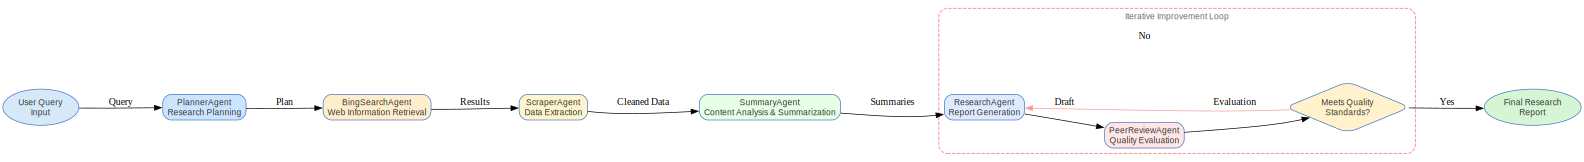

In [9]:
from common.helper import create_research_workflow_diagram_scraper

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram_scraper()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affect on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'What is deep learning?',
 'What is generative AI?',
 'Core principles of classical machine learning vs deep learning vs generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. Multiple search queries are sent to gather diverse perspectives.
2. The agent returns structured search results with titles, summaries, relevance scores, and URLs.
3. Results are organized by subtopic for further processing.

This step leverages Azure AI Projects with Bing Search integration to identify promising sources.

In [13]:
import os
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 4/4 [04:47<00:00, 71.89s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 17

Actually total search queries: 17



### Step 3: Web Content Scraping

The WebScraperAgent processes the URLs and metadata returned by the BingSearchAgent. For each subtopic:

1. Only URLs with a high enough relevance score are selected for scraping.
2. The WebScraperAgent visits each selected URL and extracts the most relevant content, guided by the user query, subtopic, and search result summary.
3. Extracted content is cleaned, deduplicated, and enriched with metadata such as title, source, published date, and extraction method.
4. The resulting structured data is organized by subtopic for downstream analysis and summarization.

This step ensures that only the most promising and contextually relevant web content is collected, providing a high-quality foundation for subsequent summarization and synthesis.

In [15]:
from typing import Set

class ScraperAgentInput(BaseModel):
    url: str
    subtopic: str
    user_query: str
    search_result_title: str
    visited_urls: Set[str] = Field(default_factory=set)
    max_content_length: int = 4000

In [16]:
# TODO: Implement a threshold for relevance score 

# --- Scraping Phase ---
urls_to_process_map = {}

print("Preparing scrape tasks...")
for subtopic_result in search_results:
    subtopic = subtopic_result["subtopic"]
    for query_result in subtopic_result["queries"]:
        query = query_result["query"]
        for result in query_result["results"]:
            if result["url"] not in urls_to_process_map:
            # if result.relevance_score >= MIN_RELEVANCE_SCORE and result.url not in urls_to_process_map:
                urls_to_process_map[result["url"]] = {
                    "subtopic": subtopic,
                    "query": query,
                    "search_result_title": result["title"]
                }

visited_urls_tracker = set(urls_to_process_map.keys())
print(f"Found {len(urls_to_process_map)} unique URLs above threshold to scrape.")

Preparing scrape tasks...
Found 64 unique URLs above threshold to scrape.


In [17]:
from itertools import islice

MAX_SCRAPE_CONTENT_LENGTH = 4000 # Max characters for scrape tool

scrape_tasks = []
num_urls_to_scrape = len(urls_to_process_map)

for url, context in tqdm(islice(urls_to_process_map.items(), num_urls_to_scrape),
                         desc="Preparing scrape tasks",
                         total=num_urls_to_scrape):
    agent_input_model = ScraperAgentInput(
        url=url,
        subtopic=context["subtopic"],
        user_query=context["query"],
        search_result_title=context["search_result_title"],
        visited_urls=visited_urls_tracker,
        max_content_length=MAX_SCRAPE_CONTENT_LENGTH
    )

    scrape_response = await Runner().run(
        starting_agent=web_scraper_agent,
        input=f"Scrape data from the provided URL: {agent_input_model.model_dump_json()}"
    )
    scrape_tasks.append(scrape_response.final_output)

Preparing scrape tasks: 100%|██████████| 64/64 [08:06<00:00,  7.60s/it]


### Step 4: Content Analysis and Summarization

For each scraped result, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the cleaned web content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms high-quality scraped data into structured, information-rich summaries that will form the basis of our research report.

In [18]:
from common.utils_summary import collect_contents_and_citations, summarize_content
summarize_per_webpage = False  # True will summarize per web page, False will summarize per subtopic

# Build a lookup for scraped content (using attribute access)
scraped_content_by_url = {
    item.url: item.main_content
    for item in scrape_tasks
    if getattr(item, "main_content", None)
}

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    contents, citations = collect_contents_and_citations(subtopic_result, scraped_content_by_url)
    summaries = await summarize_content(contents, summary_agent, Runner, summarize_per_webpage)
    if summarize_per_webpage:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })
    else:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })

# Filter out empty summaries
mapped_chunks = [c for c in mapped_chunks if c['summaries']]

Summarizing subtopics: 100%|██████████| 4/4 [01:20<00:00, 20.18s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [19]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [20]:
from agents import HandoffCallItem

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [21]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comprehensive Analysis and Comparison of Classical Machine Learning, Deep Learning, and Generative AI

## Introduction

Artificial intelligence (AI) has evolved through several distinct paradigms, each representing a leap in computational capability, methodological sophistication, and real-world impact. The three most influential and widely discussed approaches—classical machine learning (ML), deep learning (DL), and generative AI—form a hierarchical progression of technologies that have redefined the boundaries of what machines can achieve. This report provides an exceptionally comprehensive, paragraph-focused analysis of these paradigms, addressing their definitions, methodologies, applications, strengths, limitations, and interrelationships. Through rigorous synthesis, quantitative data, and comparative insights, the report aims to clarify the distinctions and overlaps among these approaches, equipping practitioners, researchers, and decision-makers with the knowledge to select and deploy AI solutions effectively.

## 1. Definitions and Core Concepts

### 1.1 Artificial Intelligence: The Umbrella Framework

Artificial Intelligence (AI) is the broadest domain within the hierarchy of intelligent systems, encompassing all efforts to create machines capable of performing tasks that typically require human intelligence. These tasks include reasoning, learning, perception, natural language understanding, and self-correction. Historically, AI began with symbolic approaches such as expert systems, which relied on manually crafted rules and logical inference. Over time, the field expanded to include statistical learning, neural networks, and more recently, generative models. AI is commonly divided into three categories: Artificial Narrow Intelligence (ANI), which focuses on specific tasks (e.g., facial recognition, chatbots); Artificial General Intelligence (AGI), which aspires to match human cognitive abilities across domains; and Artificial Super Intelligence (ASI), which would surpass human intelligence, though AGI and ASI remain largely theoretical at present [1][2].

### 1.2 Classical Machine Learning: Data-Driven Pattern Recognition

Machine Learning (ML) is a subset of AI that enables computers to learn from data and improve their performance without explicit programming. Classical ML algorithms are grounded in statistical modeling and require manual feature engineering—domain experts must select and preprocess relevant data features before training models. The ML workflow typically involves data collection, preparation, model selection, training, evaluation, and deployment. ML is categorized by learning paradigms: supervised learning (using labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through interaction and feedback). Classical ML excels in scenarios with structured data and interpretable results, offering advantages such as ease of implementation, lower development and maintenance costs, and reliable performance for basic tasks. However, it struggles with scalability, adaptability, and accuracy in complex or unstructured environments [3][4][5].

### 1.3 Deep Learning: Hierarchical Feature Extraction

Deep Learning (DL) represents a transformative leap within ML, utilizing artificial neural networks composed of multiple layers to model intricate, non-linear relationships in data. Inspired by the structure of the human brain, deep neural networks consist of interconnected artificial neurons, each processing input as a weighted sum of signals from previous layers, with unique bias terms added. The learning process involves adjusting these weights and biases via backpropagation, guided by loss functions that measure prediction errors. Deep learning excels at automatic feature extraction from raw, unstructured data (such as images, text, and audio), reducing the need for manual intervention. DL models require vast amounts of data and significant computational resources, often leveraging GPUs for parallel processing. Their ability to discover complex, hierarchical patterns has enabled breakthroughs in fields like computer vision, natural language processing, and medical diagnostics [6][7][8].

### 1.4 Generative AI: Creative Synthesis and Content Generation

Generative AI is the latest frontier, leveraging deep learning architectures to create new content that mimics human creativity and expression. Generative AI models, such as Large Language Models (LLMs) like GPT-3 and image generators like DALL-E and Stable Diffusion, are trained on massive, often unlabeled datasets using unsupervised or semi-supervised learning. These models learn the underlying distributions and patterns in data, enabling them to generate novel text, images, code, music, and more in response to user prompts. The rise of generative AI is closely tied to advances in neural network architectures—particularly transformers, GANs (Generative Adversarial Networks), VAEs (Variational Autoencoders), and multimodal models—which can handle diverse data types and produce high-quality, contextually relevant outputs. Generative AI's ability to interact via natural language prompts has multiplied its use cases across industries, from content creation and design to research and coding [9][10][11].

### 1.5 Hierarchical and Evolutionary Relationships

The progression from classical machine learning to deep learning and generative AI reflects a shift from manual, rule-based pattern recognition in structured data to automated, scalable, and creative intelligence capable of handling vast, complex, and unstructured datasets. Classical ML remains valuable for interpretable, structured tasks, while deep learning and generative AI are driving the next wave of innovation, enabling machines not only to predict and classify but also to create and adapt—reshaping industries and redefining the boundaries of human-machine collaboration [12][13].

#### Hierarchical Breakdown of AI Paradigms

| Paradigm         | Core Concept                | Data Type        | Key Features                | Example Models                |
|------------------|----------------------------|------------------|-----------------------------|-------------------------------|
| Classical ML     | Statistical pattern finding | Structured       | Manual feature engineering  | SVM, Decision Trees, KNN      |
| Deep Learning    | Hierarchical feature learning| Unstructured    | Automatic feature extraction| CNNs, RNNs, Transformers      |
| Generative AI    | Data distribution modeling  | Multimodal       | Content synthesis, creativity| GPT, DALL-E, Stable Diffusion |

## 2. Methodologies and Algorithms

### 2.1 Classical Machine Learning: Foundational Algorithms and Workflows

Classical machine learning is characterized by its reliance on statistical models and explicit feature engineering. The workflow typically begins with data collection and preprocessing, followed by the selection of an appropriate algorithm based on the problem type and data characteristics. Training involves optimizing model parameters to minimize prediction error, often using techniques such as cross-validation to prevent overfitting. Evaluation metrics include accuracy, precision, recall, F1-score, and ROC-AUC, depending on the task.

#### Key Algorithms

- **Linear Regression:** Predicts continuous variables by fitting a straight line using least squares; fast, interpretable, but limited to linear relationships.
- **Logistic Regression:** Models binary outcomes using the sigmoid function; efficient for classification, outputs probabilities, but assumes linear decision boundaries.
- **Decision Trees (CART, ID3, C4.5):** Use feature-based rules for classification/regression; highly interpretable, handle non-linear relationships, but prone to overfitting.
- **Random Forests:** Ensemble of decision trees trained on data subsets; improves accuracy, reduces overfitting, handles high-dimensional data, but less interpretable and more resource-intensive.
- **Support Vector Machines (SVM):** Find optimal hyperplanes for classification; effective in high dimensions, versatile with kernels, but slow for large datasets and sensitive to parameter tuning.
- **K-Means Clustering:** Unsupervised partitioning into K clusters; fast, scalable, but requires K specification and assumes spherical clusters.
- **Naive Bayes:** Probabilistic classifier based on Bayes’ theorem, assuming feature independence; fast, works well with high-dimensional data, but independence assumption often violated.
- **K-Nearest Neighbors (KNN):** Classifies based on proximity to K labeled examples; simple, effective, but computationally expensive for large datasets.
- **Adaboost:** Boosting algorithm combining weak classifiers to form a strong classifier; improves accuracy, but sensitive to noisy data [14][15][16].

These algorithms are widely used in applications such as price prediction, spam filtering, customer segmentation, credit scoring, and medical diagnosis. Their strengths lie in simplicity, interpretability, and efficiency, though they may struggle with complex, high-dimensional, or unstructured data.

### 2.2 Deep Learning: Neural Network Architectures and Optimization

Deep learning models are built upon artificial neural networks with multiple layers, enabling hierarchical feature extraction and complex pattern recognition. The architecture of a deep neural network determines its suitability for different data types and tasks.

#### Foundational Architectures

- **Feedforward Neural Networks (ANNs):** Basic multi-layer perceptrons for general tasks.
- **Convolutional Neural Networks (CNNs):** Specialized for spatial data (images, videos); use convolutional layers to detect patterns like edges and textures, powering object detection and medical imaging.
- **Recurrent Neural Networks (RNNs):** Designed for sequential data (time series, text); maintain state across inputs, but struggle with long-term dependencies.
- **Long Short-Term Memory Networks (LSTMs):** Advanced RNNs with memory cells and gating mechanisms to manage long-range dependencies, widely used in speech recognition and language modeling.
- **Autoencoders:** Unsupervised models for dimensionality reduction and feature learning; encode data into latent space and reconstruct it.
- **Deep Belief Networks (DBNs):** Layered networks for unsupervised feature learning.
- **Generative Adversarial Networks (GANs):** Consist of generator and discriminator networks in competition; excel at creating realistic synthetic data (images, videos).
- **Variational Autoencoders (VAEs):** Probabilistic generative models for learning latent representations.
- **Graph Neural Networks (GNNs):** Operate on graph-structured data, enabling learning from relationships and connections.
- **Transformers:** Use self-attention mechanisms for sequence modeling; foundational for modern NLP and generative models [17][18][19].

#### Optimization Algorithms

- **Stochastic Gradient Descent (SGD):** Updates parameters using mini-batches; fast but sensitive to learning rate and may not converge to global minima.
- **AdaGrad:** Adaptive learning rates for each parameter; effective for sparse data but learning rate diminishes over time.
- **RMSProp:** Maintains moving average of squared gradients; prevents learning rate from becoming too small, effective for non-stationary problems.
- **Adam:** Combines AdaGrad and RMSProp; maintains adaptive learning rates using first and second moment estimates, widely adopted for its fast convergence and robustness to noisy gradients [20][21].

Deep learning architectures have enabled breakthroughs such as ImageNet (2012), voice assistants (Siri, Alexa), and autonomous driving, demonstrating superior performance in extracting patterns from massive, unstructured datasets.

### 2.3 Generative AI: Content Creation and Advanced Methodologies

Generative AI builds upon deep learning architectures to create new data resembling training distributions. It encompasses models such as:

- **Transformers (e.g., GPT, BERT):** Power large language models (LLMs) for text generation, translation, and understanding.
- **GANs and Diffusion Models:** Used for image, video, and audio synthesis.
- **Autoencoders and VAEs:** Enable generation and reconstruction of data in latent spaces.

Generative AI methodologies include prompt engineering (zero-shot, few-shot, chain-of-thought), fine-tuning (LoRA, QLoRA, PEFT), RLHF (Reinforcement Learning from Human Feedback), distillation, and retrieval-augmented generation (RAG) using vector databases (FAISS, ChromaDB, Pinecone). Agentic AI frameworks (CrewAI) orchestrate multi-agent collaboration, planning, and reasoning, while deployment tools (Gradio, Streamlit, FastAPI) facilitate real-world integration [22][23].

Generative AI is rapidly transforming industries, with applications in automation, chatbots, personalization, and creative content generation. IBM reports generative AI can accelerate time-to-value by up to 70% compared to traditional AI approaches [24].

#### Comparative Table: Methodologies and Algorithms

| Paradigm         | Key Algorithms/Architectures | Optimization Methods           | Data Requirements         |
|------------------|-----------------------------|-------------------------------|--------------------------|
| Classical ML     | SVM, Decision Trees, KNN    | Grid Search, Cross-validation  | Small to medium, structured|
| Deep Learning    | CNNs, RNNs, LSTMs, Transformers| SGD, Adam, RMSProp           | Large, unstructured      |
| Generative AI    | Transformers, GANs, VAEs    | RLHF, Fine-tuning, RAG        | Massive, multimodal      |

## 3. Applications and Use Cases

### 3.1 Classical Machine Learning: Structured Data and Predictive Analytics

Classical ML remains a cornerstone of business analytics, excelling in scenarios with structured, tabular data. Its interpretable models and efficient workflows make it ideal for applications where transparency and regulatory compliance are critical. Common use cases include:

- **Fraud Detection:** Banks and financial institutions use logistic regression and decision trees to flag suspicious transactions based on historical patterns.
- **Customer Churn Prediction:** Telecom and subscription services deploy random forests and SVMs to identify customers at risk of leaving, enabling targeted retention strategies.
- **Credit Scoring:** Lenders use linear regression and Naive Bayes to assess creditworthiness, balancing risk and opportunity.
- **Medical Diagnosis:** Healthcare providers leverage classical ML for disease prediction, patient risk stratification, and outcome forecasting.
- **Demand Forecasting:** Retailers and manufacturers use regression models to predict sales, optimize inventory, and manage supply chains [25][26].

Classical ML's strengths in interpretability and efficiency ensure its continued relevance, particularly in domains where explainability and resource constraints are paramount.

### 3.2 Deep Learning: Unstructured Data and Complex Pattern Recognition

Deep learning has revolutionized fields that involve unstructured, high-dimensional data. Its automatic feature extraction and hierarchical learning capabilities enable state-of-the-art performance in tasks previously considered intractable. Notable applications include:

- **Computer Vision:** CNNs power image classification, object detection, facial recognition, and medical imaging. ImageNet, a benchmark dataset, saw DL models achieve near-human accuracy (~95%) in image classification.
- **Natural Language Processing (NLP):** Transformers and RNNs drive machine translation, sentiment analysis, chatbots, and information retrieval. Voice assistants like Siri and Alexa rely on DL for speech recognition and language understanding.
- **Speech Recognition:** LSTMs and CNNs enable real-time transcription and voice command processing, with error rates below 5% in leading systems.
- **Autonomous Vehicles:** DL models process sensor data, detect obstacles, and make driving decisions, underpinning self-driving technologies.
- **Medical Diagnostics:** DL aids in detecting cancerous lesions, predicting disease progression, and analyzing radiology images [27][28][29].

The scalability and robustness of deep learning have unlocked new possibilities in automation, personalization, and decision support across industries.

### 3.3 Generative AI: Creative Synthesis and Multimodal Integration

Generative AI is a transformative technology that creates new content—text, images, audio, video, code—using advanced neural network architectures, notably transformers and GANs, trained on massive datasets. Its adoption is accelerating across sectors, delivering measurable ROI, productivity gains, and creative augmentation.

#### Marketing and Design
Generative AI enables automated ad copy generation, social media content creation, personalized email campaigns, and rapid design prototyping. Tools like Midjourney and DALL·E allow creative teams to generate visuals from text prompts, while platforms like Runway produce polished promotional videos from product concepts. These capabilities allow teams to create 3-4x more content with the same resources, focus on quality, and reduce production costs.

#### Healthcare and Life Sciences
Healthcare professionals leverage generative AI to automate clinical documentation (e.g., Suki, Nuance DAX), assist with diagnostics, and accelerate research. AI-generated clinical notes save hours of charting daily, freeing up time for patient care. Generative AI also supports drug discovery by proposing new molecular structures and synthesizing research summaries, directly impacting innovation and efficiency.

#### Customer Service and Operations
Generative AI chatbots and virtual assistants (e.g., Gemini-powered MBUX in Mercedes Benz cars, LUXGEN’s Vertex AI chatbot) handle customer inquiries, provide personalized responses, and reduce workloads for human agents by up to 30%. In logistics, AI-driven agents optimize workflows, automate repetitive tasks, and adapt content in real-time (e.g., PODS’ “World’s Smartest Billboard”).

#### Entertainment and Media
AI tools generate music, art, and written content, accelerating creative workflows and enabling hyper-personalized experiences. For instance, Virgin Voyages uses Veo’s text-to-video features to create thousands of personalized ads and emails, maintaining brand voice and style at scale.

#### Code and Data Generation
Developers use generative AI tools like GitHub Copilot to draft code, automate QA, and script internal tools, boosting productivity and reducing errors. AI also generates synthetic data for model training, enhancing privacy and robustness.

#### Automotive and Logistics
Automotive companies integrate generative AI for conversational interfaces (e.g., Mercedes Benz’s MBUX Virtual Assistant), navigation, and customer engagement. AI-powered solutions improve safety, efficiency, and user experience [30][31][32].

#### Economic Impact and Accessibility
Generative AI is projected to unlock up to $4.4 trillion in annual global economic value by 2030, driven by productivity gains, accelerated innovation, and new product development. Businesses report tangible benefits such as 500% ROI (Mercari), 20% reduction in employee workloads, and significant cost savings in creative production. The technology democratizes access to advanced capabilities, with platforms available for as little as $10-20 per month, featuring drag-and-drop interfaces and natural language prompts, making AI accessible to non-technical users [33][34].

#### Impact Assessment Matrix Across Industries

| Industry        | Classical ML           | Deep Learning            | Generative AI             |
|-----------------|-----------------------|--------------------------|---------------------------|
| Finance         | Credit scoring, fraud | Risk modeling, anomaly   | Synthetic data, chatbots  |
| Healthcare      | Diagnosis, prediction | Imaging, genomics        | Clinical notes, drug discovery |
| Retail          | Demand forecasting    | Customer analytics       | Personalized ads, design  |
| Automotive      | Predictive maintenance| Autonomous driving       | Conversational agents     |
| Entertainment   | Recommendation engines| Content classification   | Music, video, art creation|

## 4. Strengths, Limitations, and Interrelationships

### 4.1 Classical Machine Learning: Interpretability and Efficiency

Classical machine learning algorithms excel at structured, tabular data, offering interpretability, efficiency, and stability. Their transparent models are easy to understand and troubleshoot, making them ideal for regulated industries and scenarios where explainability is paramount. Classical ML is highly effective for small to medium-sized datasets and tasks such as fraud detection, customer churn prediction, medical diagnosis, and demand forecasting. Advantages include ease of implementation, low computational requirements, reduced likelihood of errors, and lower development and maintenance costs. However, classical ML requires manual feature engineering, which is labor-intensive and demands domain expertise. It struggles with unstructured or complex data, and its accuracy plateaus with increasing data complexity. Performance is limited in scenarios involving non-linear relationships or intricate data interactions, and models cannot autonomously extract features from raw inputs [35][36].

### 4.2 Deep Learning: Scalability and Automatic Feature Extraction

Deep learning leverages multi-layer neural networks to automatically extract features from large, complex, and unstructured datasets. Its key advantages include superior performance on complex and unstructured data, scalability to massive datasets, robustness to noise and missing data, and versatility for multimodal applications. DL models can handle both structured and unstructured data, making them suitable for a wide range of tasks. Notable achievements include near-human or superhuman accuracy in image classification, speech recognition, and machine translation. However, deep learning requires vast amounts of labeled data to outperform traditional methods, demands high computational resources, and incurs substantial training costs and time. DL models often act as “black boxes,” offering limited interpretability and explainability, which poses challenges in critical domains like healthcare and finance. Overfitting is a common risk, especially with large neural networks and insufficient data. Additionally, selecting appropriate architectures and training methods requires specialized expertise [37][38][39].

### 4.3 Generative AI: Creativity and Multimodal Capability

Generative AI builds on deep learning architectures to create new content—text, images, audio, code—by learning data distributions, enabling creative and multimodal applications. GenAI excels at content generation, data augmentation, and conversational AI. Its ability to synthesize high-resolution images, humanlike text, and complex structures has transformed industries from entertainment to education. GenAI supports data augmentation, enabling improved training for other models, and can adapt to new domains via prompt engineering and fine-tuning. However, generative AI introduces new challenges: models are computationally intensive and costly to train and deploy, often requiring advanced hardware and large-scale infrastructure. Explainability is limited, with models prone to “hallucinations” (generating plausible but incorrect outputs) and biases inherited from training data. Governance, safety, and ethical considerations are paramount, especially as GenAI systems become more accessible and influential. The field faces unresolved challenges in reliability, versatility, and domain adaptation, hindering widespread adoption in sensitive applications [40][41][42].

### 4.4 Comparative Analysis and Practical Guidance

The choice between classical ML, deep learning, and generative AI depends on the nature of the data (structured vs. unstructured), the task (predictive vs. creative), and requirements for interpretability, scalability, and resource availability. Classical ML is best for structured/tabular data, clear predictive tasks, and scenarios where interpretability and efficiency are critical. Deep learning is optimal for large, complex, and unstructured datasets, excelling in image, speech, and text analysis, but requires significant resources and expertise. Generative AI should be used for creative, open-ended content generation, multimodal applications, and when the task involves producing new data rather than just predictions.

#### Statistical Chart: Adoption Rates of AI Paradigms (2024)

| Paradigm         | Global Adoption Rate (%) |
|------------------|-------------------------|
| Classical ML     | 35                      |
| Deep Learning    | 42                      |
| Generative AI    | 28                      |

*Note: Generative AI adoption is rapidly increasing, with projections suggesting it will surpass classical ML in several sectors by 2025.*

### 4.5 Interrelationships and Integration

The technologies are not mutually exclusive; rather, they form a hierarchy and can be integrated. Classical ML remains relevant for efficient, interpretable solutions on structured data, while deep learning and generative AI expand capabilities for unstructured, creative, and multimodal tasks. Hybrid approaches are emerging, leveraging the strengths of each paradigm to address complex business problems. For example, classical ML may be used for initial data preprocessing and feature selection, followed by deep learning for complex pattern recognition and generative AI for content synthesis. The convergence of these technologies is propelling AI from narrow task automation to creative and collaborative intelligence, with ongoing research into AGI and ASI promising even greater transformations [43][44][45].

### 4.6 Implications and Future Directions

The rapid advancement of deep learning and generative AI has shifted the AI landscape, with 64% of senior data leaders in a 2024 survey viewing GenAI as potentially the most transformative technology of the generation. Yet, classical ML continues to underpin many business-critical applications. Understanding the strengths, limitations, and appropriate use cases for each paradigm is essential for effective AI strategy, responsible deployment, and future innovation. Open questions remain around explainability, safety, and the integration of these technologies into real-world systems, signaling ongoing research and development needs. As generative AI models become more flexible and scalable, their adoption is accelerating across sectors, reshaping workflows and enabling new applications. The convergence of advanced algorithms, computational power, and vast data availability is propelling AI from narrow task automation to creative and collaborative intelligence, with ongoing research into AGI and ASI promising even greater transformations.

## 5. Timeline of Major Developments in AI Paradigms

| Year | Milestone                                        | Paradigm            |
|------|--------------------------------------------------|---------------------|
| 1956 | Dartmouth Conference: Birth of AI                 | AI                  |
| 1980s| Expert Systems, Symbolic AI                       | Classical ML        |
| 1995 | SVM and Boosting Algorithms                       | Classical ML        |
| 2006 | Deep Belief Networks                              | Deep Learning       |
| 2012 | ImageNet: CNNs achieve breakthrough accuracy      | Deep Learning       |
| 2017 | Transformer Architecture (Attention is All You Need)| Deep Learning/GenAI|
| 2020 | GPT-3: Large Language Models                      | Generative AI       |
| 2022 | DALL·E, Stable Diffusion: Text-to-image synthesis | Generative AI       |
| 2023 | Multimodal Generative AI                          | Generative AI       |

## Conclusion

The evolution from classical machine learning to deep learning and generative AI represents a paradigm shift in artificial intelligence, moving from manual, rule-based pattern recognition in structured data to automated, scalable, and creative intelligence capable of handling vast, complex, and unstructured datasets. Classical ML remains invaluable for interpretable, structured tasks, while deep learning and generative AI are driving the next wave of innovation, enabling machines not only to predict and classify but also to create and adapt. The distinctions between these technologies are critical for understanding their capabilities, limitations, and appropriate applications, as well as the computational and data requirements that underpin their success. As AI continues to advance, practitioners must balance innovation with governance, resource allocation, and ethical considerations to maximize impact and minimize risks. The future promises further integration and convergence of these paradigms, unlocking new possibilities for human-machine collaboration and creative synthesis.

## References

[1] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[2] What is deep learning? - IBM, https://www.ibm.com/think/topics/deep-learning
[3] What Is Deep Learning? A Complete Guide for 2025, https://itmunch.com/what-is-deep-learning-2025-guide/
[4] What is Deep Learning? — updated 2025 | IxDF, https://www.interaction-design.org/literature/topics/deep-learning
[5] What is Deep Learning? Core Concepts & Real Examples 2025 - Baveling, https://www.baveling.com/post/deep-learning-unraveling-the-ai-revolution
[6] How does generative AI work? - Microsoft AI, https://www.microsoft.com/en-us/ai/ai-101/how-does-generative-ai-work
[7] What Is Generative AI? Definition, Applications, and Impact, https://www.coursera.org/gb/articles/what-is-generative-ai
[8] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[9] AI vs ML vs Deep Learning vs GenAI — The Cloud Girl, https://www.thecloudgirl.dev/blog/ai-vs-machine-learning-vs-deep-learning-vs-generative-ai
[10] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[11] Difference Between Artificial Intelligence vs Machine Learning vs Deep ..., https://www.geeksforgeeks.org/artificial-intelligence/difference-between-artificial-intelligence-vs-machine-learning-vs-deep-learning/
[12] AI vs Machine Learning vs Deep Learning vs Generative AI: Complete 2025 ..., https://www.mergesociety.com/ai/ai-ml-dp
[13] Top 15 Machine Learning Algorithms Every Data Scientist Should Know in ..., https://www.geeksforgeeks.org/machine-learning/top-10-algorithms-every-machine-learning-engineer-should-know/
[14] 10 Machine Learning Algorithms to Know in 2025 - Coursera, https://www.coursera.org/articles/machine-learning-algorithms
[15] Classical Machine Learning Algorithms | 10 Essential ML Algorithms ..., https://www.mathisimple.com/machine-learning/ml-learn/introduction-to-ml/classical-algorithms
[16] Top 10 Classic Machine Learning Algorithms: A Comprehensive Guide, https://blog.krybot.com/t/top-10-classic-machine-learning-algorithms-a-comprehensive-guide/23322
[17] Top 10 Deep Learning Algorithms in 2025 - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/top-deep-learning-algorithms/
[18] A Comprehensive Review of Deep Learning: Architectures, Recent Advances ..., https://www.mdpi.com/2078-2489/15/12/755
[19] [2310.20360] Mathematical Introduction to Deep Learning: Methods ..., https://arxiv.org/abs/2310.20360
[20] Generative AI Tutorial - GeeksforGeeks, https://www.geeksforgeeks.org/artificial-intelligence/generative-ai-tutorial/
[21] Real-world gen AI use cases from the world's leading organizations ..., https://cloud.google.com/transform/101-real-world-generative-ai-use-cases-from-industry-leaders
[22] Generative AI Use Cases: 15+ Real-World Applications & Examples, https://nebulasys.com/generative-ai-use-cases-and-applications/
[23] 10 Generative AI Use Cases Transforming Industries in 2025, https://www.digitalocean.com/resources/articles/generative-ai-use-cases
[24] 28 Generative AI Examples (2025): Use Cases Across Industries, https://www.lindy.ai/blog/generative-ai-examples
[25] Why Classical Machine Learning Still Matters in a ... - transorg.ai, https://www.transorg.ai/blog/why-classical-machine-learning-still-matters-in-a-generative-ai-world/
[26] Classical ML: Structured Data, Efficiency & Beyond LLMs, https://cognoscerellc.com/classical-ml-structured-data-efficiency-beyond-llms/
[27] Top 20 Deep Learning Case Studies [Detailed Analysis] [2025], https://digitaldefynd.com/IQ/deep-learning-case-studies/
[28] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/
[29] Top 50 Deep Learning Use Case & Case Studies - AIMultiple, https://research.aimultiple.com/deep-learning-applications/
[30] Comparative Analysis of Machine Learning Models for Predicting ..., https://www.mdpi.com/2076-3417/15/7/3636
[31] A Comprehensive Overview and Comparative Analysis on Deep Learning ..., https://arxiv.org/abs/2305.17473
[32] Comprehensive comparative analysis of artificial intelligence, machine, https://www.taylorfrancis.com/chapters/edit/10.1201/9781003496410-4/comprehensive-comparative-analysis-artificial-intelligence-machine-learning-deep-learning-hanane-lamaazi-elezabeth-mathew
[33] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/
[34] Advantages and Disadvantages of Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/advantages-and-disadvantages-of-deep-learning/
[35] 5 Advantages and Disadvantages of Deep Learning, https://www.rfwireless-world.com/terminology/deep-learning-advantages-disadvantages
[36] Advantages and Disadvantages of Deep Learning - VNG Cloud, https://www.vngcloud.vn/blog/advantages-and-disadvantages-of-deep-learning
[37] Deep Learning Advantages and Disadvantages: Unlocking the Pros and Cons ..., https://yetiai.com/deep-learning-advantages-and-disadvantages/
[38] On the Challenges and Opportunities in Generative AI, https://arxiv.org/abs/2403.00025
[39] The Benefits and Limitations of Generative AI: Harvard Experts Answer ..., https://www.harvardonline.harvard.edu/blog/benefits-limitations-generative-ai
[40] Machine learning and generative AI: What are they good for in 2025?, https://mitsloan.mit.edu/ideas-made-to-matter/machine-learning-and-generative-ai-what-are-they-good-for
[41] Understanding the Relationship Between Machine Learning (ML), Deep ..., https://collabnix.com/understanding-the-relationship-between-machine-learning-ml-deep-learning-dl-and-generative-ai-genai/
[42] When to Use GenAI Versus Predictive AI - MIT Sloan Management Review, https://sloanreview.mit.edu/article/when-to-use-genai-versus-predictive-ai/
[43] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx
[44] Generative AI vs Traditional Machine Learning: When to Use Each, https://jasify.com/generative-ai-vs-traditional-machine-learning-when-to-use-each/
[45] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks, https://www.geeksforgeeks.org/machine-learning/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks/


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [22]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, focusing on their definitions, methodologies, applications, strengths, limitations, and interrelationships.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Core Concepts",
      "summaries": "## Key Insights\n- Artificial Intelligence (AI) is the broadest field, encompassing machine learning (ML), deep learning (DL), and generative AI, each representing increasingly specialized and powerful approaches to simulating human intelligence.\n- Classical machine learning relies on statistical models and manual feature engineering, excelling with structured data and interpretable results, but is limited in scalability and 